In [72]:
import pandas as pd
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve, auc, precision_recall_curve
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import RFE
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss
from sklearn.decomposition import PCA
import optuna
import numpy as np
import matplotlib.pyplot as plt


### Information of train and test datasets

In [64]:
train = pd.read_csv('train.csv')
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   15000 non-null  int64  
 1   age                  15000 non-null  float64
 2   height(cm)           15000 non-null  float64
 3   weight(kg)           15000 non-null  float64
 4   waist(cm)            15000 non-null  float64
 5   eyesight(left)       15000 non-null  float64
 6   eyesight(right)      15000 non-null  float64
 7   hearing(left)        15000 non-null  float64
 8   hearing(right)       15000 non-null  float64
 9   systolic             15000 non-null  float64
 10  relaxation           15000 non-null  float64
 11  fasting blood sugar  15000 non-null  float64
 12  Cholesterol          15000 non-null  float64
 13  triglyceride         15000 non-null  float64
 14  HDL                  15000 non-null  float64
 15  LDL                  15000 non-null 

In [65]:
test = pd.read_csv('test.csv')
sbm = pd.read_csv("sample_submission.csv")


## Optuna

In [60]:
# Separate features and target
X = train.drop('smoking', axis=1)
y = train['smoking']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Objective function for Optuna
def objective(trial):
    # Suggest hyperparameters to search
    n_estimators = trial.suggest_int("n_estimators", 50, 500)
    max_depth = trial.suggest_int("max_depth", 2, 50)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 20)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)
    max_features = trial.suggest_categorical("max_features", ["sqrt", "log2", None])
    bootstrap = trial.suggest_categorical("bootstrap", [True, False])

    # Create the model with suggested hyperparameters
    rf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        bootstrap=bootstrap,
        random_state=42,
        n_jobs=-1
    )

    # Evaluate using cross-validation (with ROC-AUC as scoring metric)
    roc_auc = cross_val_score(rf, X_train, y_train, cv=3, scoring="roc_auc", n_jobs=-1).mean()
    
    return roc_auc

# Create and run an Optuna study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

print("Best Parameters:", study.best_params)
print("Best ROC-AUC:", study.best_value)

# Train the best model on the full training set
best_rf = RandomForestClassifier(**study.best_params, random_state=42, n_jobs=-1)
best_rf.fit(X_train, y_train)

# Evaluate on the test set
test_roc_auc = roc_auc_score(y_test, best_rf.predict_proba(X_test)[:, 1])
print("Test ROC-AUC:", test_roc_auc)


[I 2024-10-26 21:30:58,421] A new study created in memory with name: no-name-c93c4f01-9fba-4955-b20b-658017fc609c
[I 2024-10-26 21:31:02,852] Trial 0 finished with value: 0.8804990147504058 and parameters: {'n_estimators': 429, 'max_depth': 11, 'min_samples_split': 19, 'min_samples_leaf': 8, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 0 with value: 0.8804990147504058.
[I 2024-10-26 21:31:13,807] Trial 1 finished with value: 0.7809851687647877 and parameters: {'n_estimators': 328, 'max_depth': 45, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_features': None, 'bootstrap': False}. Best is trial 0 with value: 0.8804990147504058.
[I 2024-10-26 21:31:20,063] Trial 2 finished with value: 0.8770362482593211 and parameters: {'n_estimators': 321, 'max_depth': 48, 'min_samples_split': 9, 'min_samples_leaf': 6, 'max_features': None, 'bootstrap': True}. Best is trial 0 with value: 0.8804990147504058.
[I 2024-10-26 21:31:21,161] Trial 3 finished with value: 0.8817656535220211 a

Best Parameters: {'n_estimators': 390, 'max_depth': 18, 'min_samples_split': 15, 'min_samples_leaf': 5, 'max_features': 'log2', 'bootstrap': False}
Best ROC-AUC: 0.8822056245442363
Test ROC-AUC: 0.8866972677346666


In [12]:

# Separate features and target
X = train.drop('smoking', axis=1)
y = train['smoking']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def objective(trial):
    # Define hyperparameters for the trial
    n_estimators = trial.suggest_int('n_estimators', 300, 550)
    max_depth = trial.suggest_int('max_depth', 5, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 300)

    # Initialize classifier with the suggested hyperparameters
    rf = RandomForestClassifier(
        n_estimators=n_estimators, 
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        n_jobs=-1,
        bootstrap=True,
        random_state=42
    )

    # Use StratifiedKFold to get train/validation splits
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    val_scores = []

    # Perform cross-validation
    for train_index, val_index in cv.split(X_train, y_train):
        X_t, X_v = X_train.iloc[train_index], X_train.iloc[val_index]
        y_t, y_v = y_train.iloc[train_index], y_train.iloc[val_index]

        # Train the model
        rf.fit(X_t, y_t)

        # Compute ROC-AUC for validation set
        val_score = roc_auc_score(y_v, rf.predict_proba(X_v)[:, 1])
        val_scores.append(val_score)

    # Return the mean validation ROC-AUC score for this trial
    return np.mean(val_scores)

# Create and run the Optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

# Print the best parameters and score
print("Best Parameters (Optuna):", study.best_params)
print("Best Score (Optuna):", study.best_value)


[I 2024-10-26 10:03:30,535] A new study created in memory with name: no-name-ace3581e-cf18-4aff-b51b-e0ed5ee60645
[I 2024-10-26 10:03:32,541] Trial 0 finished with value: 0.8670830690588355 and parameters: {'n_estimators': 466, 'max_depth': 18, 'min_samples_split': 11, 'min_samples_leaf': 139}. Best is trial 0 with value: 0.8670830690588355.
[I 2024-10-26 10:03:34,613] Trial 1 finished with value: 0.8638811665706597 and parameters: {'n_estimators': 532, 'max_depth': 27, 'min_samples_split': 18, 'min_samples_leaf': 188}. Best is trial 0 with value: 0.8670830690588355.
[I 2024-10-26 10:03:35,769] Trial 2 finished with value: 0.860297768337973 and parameters: {'n_estimators': 305, 'max_depth': 28, 'min_samples_split': 9, 'min_samples_leaf': 272}. Best is trial 0 with value: 0.8670830690588355.
[I 2024-10-26 10:03:37,015] Trial 3 finished with value: 0.8683484719460846 and parameters: {'n_estimators': 307, 'max_depth': 14, 'min_samples_split': 16, 'min_samples_leaf': 116}. Best is trial 3 

Best Parameters (Optuna): {'n_estimators': 380, 'max_depth': 50, 'min_samples_split': 6, 'min_samples_leaf': 4}
Best Score (Optuna): 0.8829643989778942


## Calibration

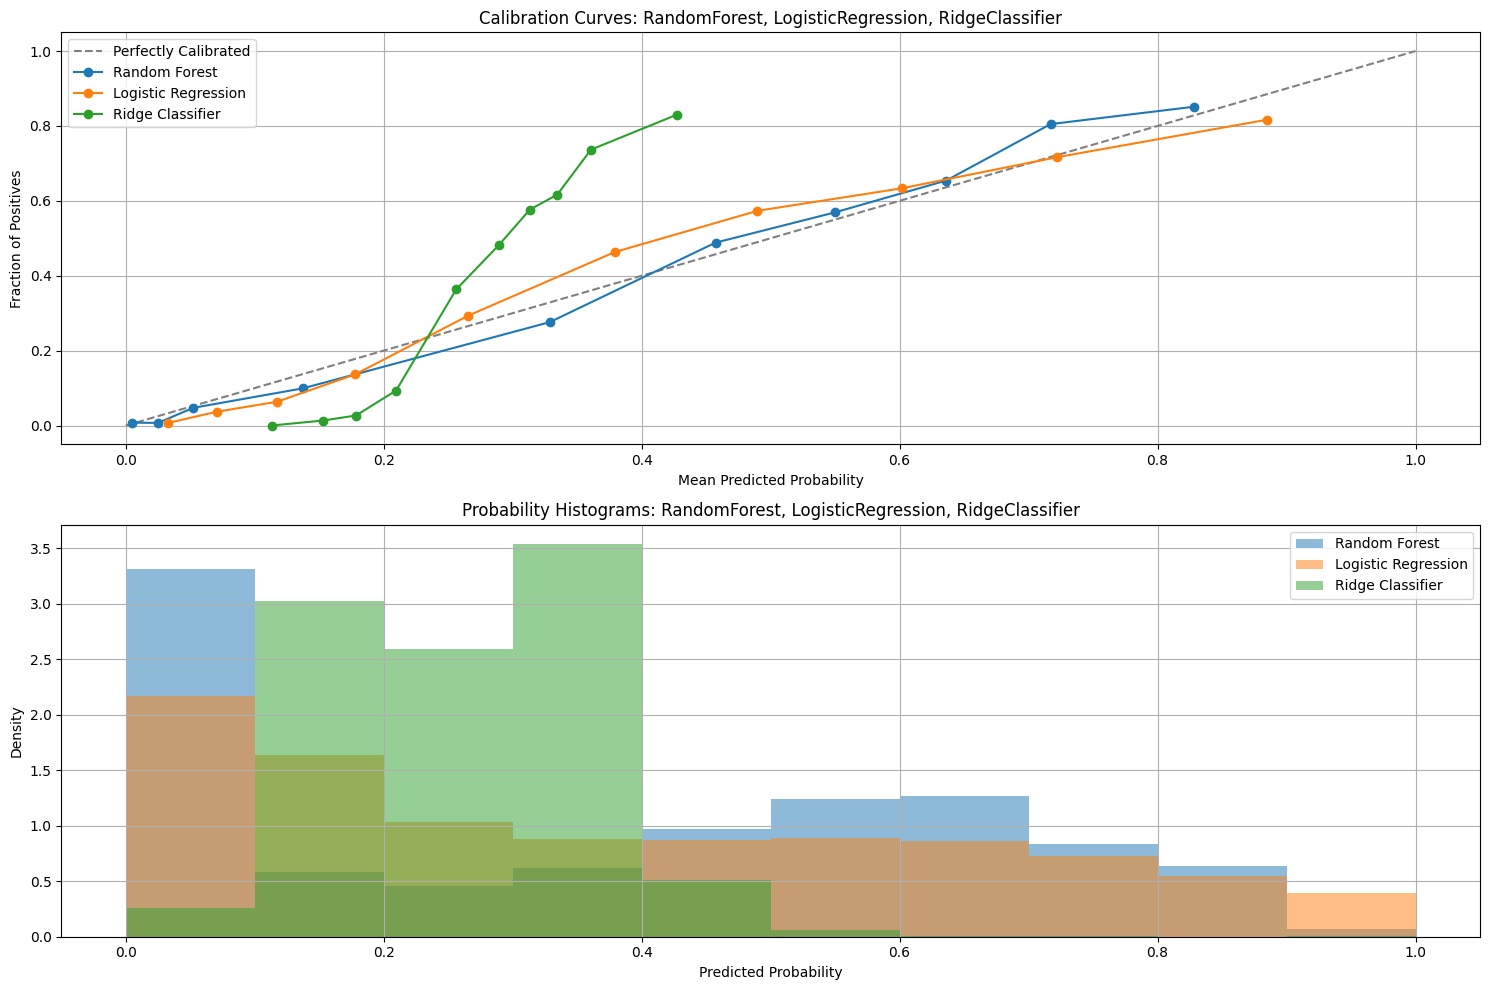

Random Forest Brier Score: 0.1343
Logistic Regression Brier Score: 0.1524
Ridge Classifier Brier Score: 0.1987


In [66]:

X = train.drop('smoking', axis=1)
y = train['smoking']

# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train models without calibration
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Logistic Regression': LogisticRegression(solver='liblinear', random_state=42),
    'Ridge Classifier': RidgeClassifier()
}

# Dictionary to store predicted probabilities
probs = {}

# Train each model and get predicted probabilities
for name, model in models.items():
    model.fit(X_train, y_train)
    # RidgeClassifier doesn't have predict_proba; we use decision_function and scale it
    if hasattr(model, "predict_proba"):
        probs[name] = model.predict_proba(X_test)[:, 1]
    else:
        # Convert decision function output to probabilities using min-max scaling
        decision_values = model.decision_function(X_test)
        probs[name] = (decision_values - decision_values.min()) / (decision_values.max() - decision_values.min())

# Plot calibration curves and probability histograms
def plot_calibration_and_histograms(y_true, probs, title):
    plt.figure(figsize=(15, 10))

    # Calibration curve subplot
    plt.subplot(2, 1, 1)
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')

    for name, prob in probs.items():
        prob_true, prob_pred = calibration_curve(y_true, prob, n_bins=10, strategy='quantile')
        plt.plot(prob_pred, prob_true, marker='o', label=name)

    plt.title(f'Calibration Curves: {title}')
    plt.xlabel('Mean Predicted Probability')
    plt.ylabel('Fraction of Positives')
    plt.legend(loc='best')
    plt.grid()

    # Probability histogram subplot
    plt.subplot(2, 1, 2)
    for name, prob in probs.items():
        plt.hist(prob, bins=10, alpha=0.5, label=name, range=(0, 1), density=True)

    plt.title(f'Probability Histograms: {title}')
    plt.xlabel('Predicted Probability')
    plt.ylabel('Density')
    plt.legend(loc='best')
    plt.grid()

    plt.tight_layout()
    plt.show()

# Plot calibration curves and probability histograms for all models
plot_calibration_and_histograms(y_test, probs, 'RandomForest, LogisticRegression, RidgeClassifier')

# Calculate and display Brier scores for each model
for name, prob in probs.items():
    brier = brier_score_loss(y_test, prob)
    print(f'{name} Brier Score: {brier:.4f}')


Brier Score (Uncalibrated): 0.1326


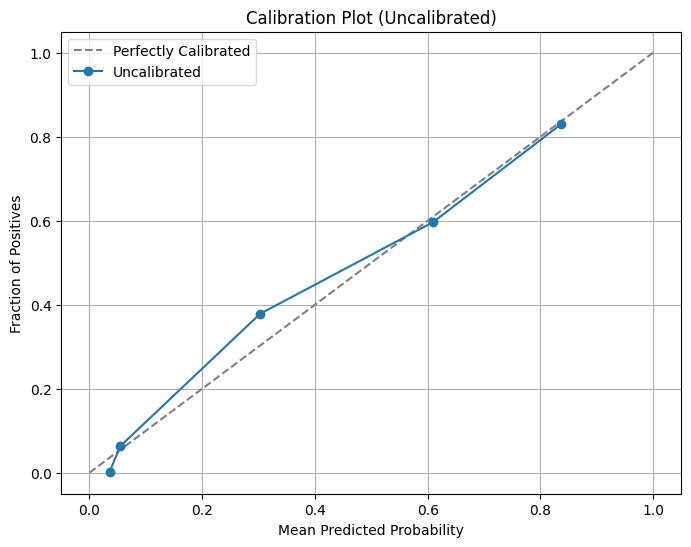

Brier Score (Sigmoid Calibration): 0.1321
Brier Score (Isotonic Calibration): 0.1313


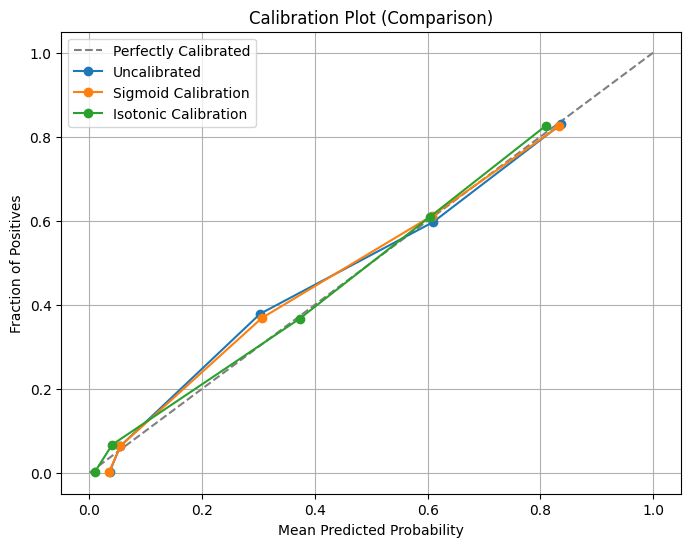

In [71]:
X = train.drop('smoking', axis=1)
y = train['smoking']

# Define base estimators (with preprocessing if necessary)
logistic_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2)),
    ('logistic', LogisticRegression(max_iter=10000,
                                 C=0.01,
                                 random_state=1))
])

random_forest = RandomForestClassifier(
    n_estimators=390,
    max_depth=18,
    min_samples_split=15,
    min_samples_leaf=5,
    max_features='log2',
    bootstrap=False,
    random_state=42,
    n_jobs=-1
)

# Define stacking classifier
stacking_clf = StackingClassifier(
    estimators=[
        ('logistic', logistic_pipeline),
        ('random_forest', random_forest)
    ],
    final_estimator=LogisticRegression(random_state=42),
    cv=5
)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit stacking model
stacking_clf.fit(X_train, y_train)

# Get predicted probabilities for the positive class
y_prob_uncalibrated = stacking_clf.predict_proba(X_test)[:, 1]


# Calculate Brier score for the uncalibrated model
brier_uncalibrated = brier_score_loss(y_test, y_prob_uncalibrated)
print(f"Brier Score (Uncalibrated): {brier_uncalibrated:.4f}")

# Function to plot calibration curves
def plot_calibration_curve(y_true, y_probs_list, labels, title):
    plt.figure(figsize=(8, 6))
    plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly Calibrated', color='gray')
    for y_prob, label in zip(y_probs_list, labels):
        prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=5, strategy='quantile')
        plt.plot(prob_pred, prob_true, marker='o', label=label)
    plt.title(title)
    plt.xlabel('Mean Predicted Probability')
    plt.ylabel('Fraction of Positives')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

# Plot calibration curve for uncalibrated model
plot_calibration_curve(y_test, [y_prob_uncalibrated], ['Uncalibrated'], 'Calibration Plot (Uncalibrated)')

# Apply Platt scaling (sigmoid) calibration
rf_sigmoid = CalibratedClassifierCV(stacking_clf, method='sigmoid', cv=4)
rf_sigmoid.fit(X_train, y_train)
y_prob_sigmoid = rf_sigmoid.predict_proba(X_test)[:, 1]

# Calculate Brier score for sigmoid-calibrated model
brier_sigmoid = brier_score_loss(y_test, y_prob_sigmoid)
print(f"Brier Score (Sigmoid Calibration): {brier_sigmoid:.4f}")

# Apply Isotonic regression calibration
rf_isotonic = CalibratedClassifierCV(stacking_clf, method='isotonic', cv=4)
rf_isotonic.fit(X_train, y_train)
y_prob_isotonic = rf_isotonic.predict_proba(X_test)[:, 1]

# Calculate Brier score for isotonic-calibrated model
brier_isotonic = brier_score_loss(y_test, y_prob_isotonic)
print(f"Brier Score (Isotonic Calibration): {brier_isotonic:.4f}")

# Plot calibration curves for all three models
plot_calibration_curve(
    y_test,
    [y_prob_uncalibrated, y_prob_sigmoid, y_prob_isotonic],
    ['Uncalibrated', 'Sigmoid Calibration', 'Isotonic Calibration'],
    'Calibration Plot (Comparison)'
)


In [62]:
# Calculate Brier score for the uncalibrated model
brier_uncalibrated = roc_auc_score(y_test, y_prob_uncalibrated)
print(f"Brier Score (Uncalibrated): {brier_uncalibrated:.4f}")

# Calculate Brier score for sigmoid-calibrated model
brier_sigmoid = roc_auc_score(y_test, y_prob_sigmoid)
print(f"Brier Score (Sigmoid Calibration): {brier_sigmoid:.4f}")


# Calculate Brier score for isotonic-calibrated model
brier_isotonic = roc_auc_score(y_test, y_prob_isotonic)
print(f"Brier Score (Isotonic Calibration): {brier_isotonic:.4f}")

Brier Score (Uncalibrated): 0.8867
Brier Score (Sigmoid Calibration): 0.8875
Brier Score (Isotonic Calibration): 0.8868


In [69]:

X = train.drop('smoking', axis=1)
y = train['smoking']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a simple RandomForestClassifier
rf = RandomForestClassifier(
    n_estimators=390,
    max_depth=18,
    min_samples_split=15,
    min_samples_leaf=5,
    max_features='log2',
    bootstrap=False,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)


# Function to plot calibration curves
def plot_calibration_curve(y_true, y_probs_list, labels, title):
    plt.figure(figsize=(8, 6))
    plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly Calibrated', color='gray')
    for y_prob, label in zip(y_probs_list, labels):
        prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=5, strategy='quantile')
        plt.plot(prob_pred, prob_true, marker='o', label=label)
    plt.title(title)
    plt.xlabel('Mean Predicted Probability')
    plt.ylabel('Fraction of Positives')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

# Apply Isotonic regression calibration
rf_isotonic = CalibratedClassifierCV(rf, method='isotonic', cv=4)
rf_isotonic.fit(X_train, y_train)
y_prob_isotonic = rf_isotonic.predict_proba(X_test)[:, 1]
# Calculate Brier score for isotonic-calibrated model
brier_isotonic = brier_score_loss(y_test, y_prob_isotonic)
print(f"Brier Score (Isotonic Calibration): {brier_isotonic:.4f}")

brier_isotonic = roc_auc_score(y_test, y_prob_isotonic)
print(f"Roc-auc (Isotonic Calibration): {brier_isotonic:.4f}")

# Plot calibration curves for all three models
plot_calibration_curve(
    y_test,
    [y_prob_isotonic],
    ['Isotonic Calibration'],
    'Calibration Plot'
)



#y_prob_isotonic = rf_isotonic.predict_proba(test)[:, 1]
#
#subm = pd.read_csv("sample_submission.csv")
#subm['smoking'] = y_prob_isotonic
#subm.to_csv("my_submission_1.csv", index=False)


## PCE 

In [79]:
X = train.drop('smoking', axis=1)
y = train['smoking']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA to reduce to 5 components (adjust the number as needed)
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X_scaled)

# Convert PCA components into a DataFrame
pca_df = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(5)])

## Print explained variance ratio of each component
#print("Explained Variance Ratio:", pca.explained_variance_ratio_)
#print("Total Explained Variance:", sum(pca.explained_variance_ratio_))

# Train-test split (optional, if you'd like to use PCA-transformed data in modeling)
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# Define base estimators (with preprocessing if necessary)
logistic_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2)),
    ('logistic', LogisticRegression(max_iter=10000,
                                 C=0.01,
                                 random_state=1))
])

random_forest = RandomForestClassifier(
    n_estimators=390,
    max_depth=18,
    min_samples_split=15,
    min_samples_leaf=5,
    max_features='log2',
    bootstrap=False,
    random_state=42,
    n_jobs=-1
)

# Define stacking classifier
stacking_clf = StackingClassifier(
    estimators=[
        ('logistic', logistic_pipeline),
        ('random_forest', random_forest)
    ],
    final_estimator=LogisticRegression(random_state=42),
    cv=5
)

# Fit stacking model
stacking_clf.fit(X_train, y_train)

roc_auc_train = cross_val_score(stacking_clf, X_train, y_train, cv=5, scoring="roc_auc", n_jobs=-1).mean()
roc_auc_test = cross_val_score(stacking_clf, X_test, y_test, cv=5, scoring="roc_auc", n_jobs=-1).mean()
print(roc_auc_train)
print(roc_auc_test)


0.8235977158828856
0.8222882299335812


## RFE

In [76]:
X = train.drop('smoking', axis=1)
y = train['smoking']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the model
model = RandomForestClassifier(n_estimators=390,
    max_depth=18,
    min_samples_split=15,
    min_samples_leaf=5,
    max_features='log2',
    bootstrap=False,
    random_state=42,
    n_jobs=-1
)

# Recursive Feature Elimination with 5 selected features
rfe = RFE(estimator=model, n_features_to_select=22)  # Adjust number of features as desired
rfe.fit(X_train, y_train)

# Get selected features
selected_features = X.columns[rfe.support_]
print("Selected Features:", selected_features)

Selected Features: Index(['id', 'age', 'height(cm)', 'weight(kg)', 'waist(cm)', 'eyesight(left)',
       'eyesight(right)', 'hearing(right)', 'systolic', 'relaxation',
       'fasting blood sugar', 'Cholesterol', 'triglyceride', 'HDL', 'LDL',
       'hemoglobin', 'Urine protein', 'serum creatinine', 'AST', 'ALT', 'Gtp',
       'dental caries'],
      dtype='object')


### Pipeline with random forest

In [45]:
X = train.drop(columns=['smoking'], axis=1)
y = train['smoking']

logistic_model = Pipeline([
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2)),
    ('model', RandomForestClassifier(
        n_estimators=147,
        max_depth=5,
        min_samples_split=14,
        max_features='sqrt',
        bootstrap=True,
        random_state=1,
        n_jobs=-1
    ))
])

#logistic_model.fit(X, y)
#y_test_score = logistic_model.predict_proba(test[X.columns])[:, 1]
#
#test['smoking'] = y_test_score
#test[['id', 'smoking']].to_csv('my_submission_1.csv', index=False)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42,)
roc_auc_train = cross_val_score(logistic_model, X_train, y_train, cv=5, scoring="roc_auc", n_jobs=-1).mean()
roc_auc_test = cross_val_score(logistic_model, X_test, y_test, cv=5, scoring="roc_auc", n_jobs=-1).mean()
print(roc_auc_train)
print(roc_auc_test)

0.8705576885893433
0.8727207354497354


### Stackking 

In [58]:
# Define base estimators (with preprocessing if necessary)
logistic_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2)),
    ('logistic', LogisticRegression(max_iter=10000,
                                 C=0.01,
                                 random_state=1))
])

random_forest = RandomForestClassifier(
    n_estimators=350,
    max_depth=30,
    min_samples_split=6,
    min_samples_leaf=4,
    max_features='sqrt',
    bootstrap=False,
    random_state=42,
    n_jobs=-1
)

# Define stacking classifier
stacking_clf = StackingClassifier(
    estimators=[
        ('logistic', logistic_pipeline),
        ('random_forest', random_forest)
    ],
    final_estimator=LogisticRegression(random_state=42),
    cv=5
)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit stacking model
stacking_clf.fit(X_train, y_train)

# Evaluate using cross-validation
#cv_scores = cross_val_score(stacking_clf, X_train, y_train, cv=5, scoring='roc_auc')
#print("Cross-Validation AUC Scores:", cv_scores)
#print("Mean Cross-Validation AUC Score:", cv_scores.mean())

## Predict and evaluate on test set
#y_pred_proba = stacking_clf.predict_proba(test)[:, 1]
#
## 12. Bashoratlarni saqlash
#subm = pd.read_csv("sample_submission.csv")
#subm['smoking'] = y_pred_proba
#subm.to_csv("my_submission_1.csv", index=False)


roc_auc_train = cross_val_score(stacking_clf, X_train, y_train, cv=5, scoring="roc_auc", n_jobs=-1).mean()
roc_auc_test = cross_val_score(stacking_clf, X_test, y_test, cv=5, scoring="roc_auc", n_jobs=-1).mean()
print(roc_auc_train)
print(roc_auc_test)


0.8392567138306442
0.8025896677642688


##### Stacking with svc

In [57]:
# Define the stacking model with diverse base estimators
stacking_clf = StackingClassifier(
    estimators=[
        ('logistic', LogisticRegression(solver='saga', C=0.01, max_iter=20000, random_state=1)),
        ('random_forest', RandomForestClassifier(
            n_estimators=350, max_depth=30, min_samples_split=6, 
            min_samples_leaf=4, max_features='sqrt', bootstrap=False, random_state=42, n_jobs=-1
        )),
        ('svc', SVC(probability=True, kernel='rbf', random_state=42))
    ],
    final_estimator=LogisticRegression(random_state=42),
    cv=StratifiedKFold(n_splits=5)
)

#stacking_clf.fit(X_train, y_train)
# Predict and evaluate on test set
#y_pred_proba = stacking_clf.predict_proba(test)[:, 1]



# 12. Bashoratlarni saqlash
#subm = pd.read_csv("sample_submission.csv")
#subm['smoking'] = y_pred_proba
#subm.to_csv("my_submission_1.csv", index=False)

# Fit and evaluate
#y_pred_proba = stacking_clf.predict_proba(X_test)[:, 1]
#print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_proba))

roc_auc_train = cross_val_score(stacking_clf, X_train, y_train, cv=3, scoring="roc_auc", n_jobs=-1).mean()
roc_auc_test = cross_val_score(stacking_clf, X_test, y_test, cv=3, scoring="roc_auc", n_jobs=-1).mean()
print(roc_auc_train)
print(roc_auc_test)


0.8826927484012059
0.8761212007312364


## Blending

In [106]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score

X = train.drop('smoking', axis=1)
y = train['smoking']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features for logistic regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
test_scaled = scaler.transform(test)

# Initialize and train models
rf_model = RandomForestClassifier(
    n_estimators=390,
    max_depth=18,
    min_samples_split=15,
    min_samples_leaf=5,
    max_features='log2',
    bootstrap=False,
    random_state=42,
    n_jobs=-1
)
logistic_model = LogisticRegression(max_iter=10000, random_state=1)

rf_model.fit(X_train, y_train)
logistic_model.fit(X_train_scaled, y_train)

# Get predictions and blend them
rf_pred_proba = rf_model.predict_proba(test)[:, 1]
logistic_pred_proba = logistic_model.predict_proba(test_scaled)[:, 1]

# Blend predictions with simple averaging
blended_pred_proba = (rf_pred_proba + logistic_pred_proba) / 2

#blended_roc_auc = roc_auc_score(y_test, blended_pred_proba)
#blended_roc_auc_train = roc_auc_score(y_train, blended_pred_proba)

#print("Blended Model ROC-AUC Score:", blended_roc_auc)
#print("Blended Model ROC-AUC Score train:", blended_roc_auc_train)

subm = pd.read_csv("sample_submission.csv")
subm['smoking'] = blended_pred_proba
subm.to_csv("my_submission_1.csv", index=False)



InvalidParameterError: The 'estimator' parameter of CalibratedClassifierCV must be an object implementing 'fit' and 'predict_proba', an object implementing 'fit' and 'decision_function' or None. Got array([0.80108591, 0.02198435, 0.06160603, ..., 0.3057151 , 0.0267636 ,
       0.70659836]) instead.

simple = 0.88159
with randomforest hyperparametr = 0.88196


## Bagging

In [100]:


# Define bagging parameters
n_bags = 5  # Number of bags
rf_bag_predictions = []

# Bagging with RandomForestClassifier
for seed in range(n_bags):
    rf_bag = RandomForestClassifier(n_estimators=200, random_state=seed)
    rf_bag.fit(X_train, y_train)
    rf_bag_pred_proba = rf_bag.predict_proba(test)[:, 1]
    rf_bag_predictions.append(rf_bag_pred_proba)

# Average predictions across bags
bagged_rf_pred_proba = np.mean(rf_bag_predictions, axis=0)
#bagged_rf_roc_auc = roc_auc_score(y_test, bagged_rf_pred_proba)

#print("Bagged Model ROC-AUC Score:", bagged_rf_roc_auc)

#y_pred_proba = bagged_rf_pred_proba.predict_proba(test)[:, 1]
subm = pd.read_csv("sample_submission.csv")
subm['smoking'] = bagged_rf_pred_proba
subm.to_csv("my_submission_1.csv", index=False)

simple = 0.8882389
with rf hyperparametres = 0.996204

## Voting

In [118]:
X = train.drop('smoking', axis=1)
y = train['smoking']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features for models that require scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
test_scaled = scaler.transform(test)

# Define individual classifiers
rf_clf = RandomForestClassifier(
    n_estimators=390,
    max_depth=18,
    min_samples_split=15,
    min_samples_leaf=5,
    max_features='log2',
    bootstrap=False,
    random_state=42,
    n_jobs=-1
)
logistic_clf = LogisticRegression(max_iter=2000,
                                 C=0.01,
                                 random_state=1)
svm_clf = SVC(probability=True, random_state=1)  # probability=True for soft voting

# Create a VotingClassifier with soft voting
voting_clf = VotingClassifier(
    estimators=[
        ('random_forest', rf_clf),
        ('logistic', logistic_clf),
        ('svm', svm_clf)
    ],
    voting='soft'  # Use 'soft' voting for probability averaging
)

# Fit the voting classifier on the scaled training data
voting_clf.fit(X_train_scaled, y_train)



## Predict and evaluate on test set
#y_pred_proba = voting_clf.predict_proba(test_scaled)[:, 1]
#
## 12. Bashoratlarni saqlash
#subm = pd.read_csv("sample_submission.csv")
#subm['smoking'] = y_pred_proba
#subm.to_csv("my_submission_1.csv", index=False)

# Predict probabilities and evaluate
y_pred_proba = voting_clf.predict_proba(X_test_scaled)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)
print("Voting Classifier ROC-AUC Score:", roc_auc)

y_pred_proba = voting_clf.predict_proba(X_train_scaled)[:, 1]
roc_auc_train = roc_auc_score(y_train, y_pred_proba)
print("Voting Classifier ROC-AUC Score train:", roc_auc_train)


Voting Classifier ROC-AUC Score: 0.884915685705011
Voting Classifier ROC-AUC Score train: 0.9465499275481875


Simple: Voting Classifier ROC-AUC Score: 0.8843646956313748
        Voting Classifier ROC-AUC Score train: 0.9738917858830574
with hyperparametr: Voting Classifier ROC-AUC Score: 0.884915685705011
                        Voting Classifier ROC-AUC Score train: 0.9465499275481875



In [119]:
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
import pandas as pd

# Assuming 'train' and 'test' datasets are already loaded
X = train.drop('smoking', axis=1)
y = train['smoking']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
test_scaled = scaler.transform(test)

# Define individual classifiers
rf_clf = RandomForestClassifier(
    n_estimators=390,
    max_depth=18,
    min_samples_split=15,
    min_samples_leaf=5,
    max_features='log2',
    bootstrap=False,
    random_state=42,
    n_jobs=-1
)
logistic_clf = LogisticRegression(max_iter=2000, C=0.01, random_state=1)
svm_clf = SVC(probability=True, random_state=1)  # probability=True for soft voting

# Create a VotingClassifier with soft voting
voting_clf = VotingClassifier(
    estimators=[
        ('random_forest', rf_clf),
        ('logistic', logistic_clf),
        ('svm', svm_clf)
    ],
    voting='soft'  # Use 'soft' voting for probability averaging
)

# Wrap VotingClassifier with CalibratedClassifierCV
calibrated_voting_clf = CalibratedClassifierCV(voting_clf, method='isotonic', cv=5)

# Fit the calibrated voting classifier on the scaled training data
calibrated_voting_clf.fit(X_train_scaled, y_train)

# Predict probabilities and evaluate on test set
y_pred_proba = calibrated_voting_clf.predict_proba(X_test_scaled)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)
print("Calibrated Voting Classifier ROC-AUC Score (Test):", roc_auc)

# Predict and evaluate on train set
y_pred_proba_train = calibrated_voting_clf.predict_proba(X_train_scaled)[:, 1]
roc_auc_train = roc_auc_score(y_train, y_pred_proba_train)
print("Calibrated Voting Classifier ROC-AUC Score (Train):", roc_auc_train)

# Save predictions for submission
subm = pd.read_csv("sample_submission.csv")
subm['smoking'] = calibrated_voting_clf.predict_proba(test_scaled)[:, 1]
subm.to_csv("my_submission_1.csv", index=False)


Calibrated Voting Classifier ROC-AUC Score (Test): 0.8845239179997684
Calibrated Voting Classifier ROC-AUC Score (Train): 0.9377692605734482


In [121]:
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
import pandas as pd

# Assuming 'train' and 'test' datasets are already loaded
X = train.drop('smoking', axis=1)
y = train['smoking']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
test_scaled = scaler.transform(test)

# Define individual classifiers with class_weight='balanced'
rf_clf = RandomForestClassifier(
    n_estimators=390,
    max_depth=18,
    min_samples_split=15,
    min_samples_leaf=5,
    max_features='log2',
    bootstrap=False,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'  # Handle class imbalance
)
logistic_clf = LogisticRegression(
    max_iter=2000,
    C=0.01,
    random_state=1,
    class_weight='balanced'  # Handle class imbalance
)
svm_clf = SVC(probability=True, random_state=1)  # SVM doesn't support class_weight='balanced' in this Voting setup

# Create a VotingClassifier with soft voting
voting_clf = VotingClassifier(
    estimators=[
        ('random_forest', rf_clf),
        ('logistic', logistic_clf),
        ('svm', svm_clf)
    ],
    voting='soft'  # Use 'soft' voting for probability averaging
)

# Wrap VotingClassifier with CalibratedClassifierCV
calibrated_voting_clf = CalibratedClassifierCV(voting_clf, method='isotonic', cv=5)

# Fit the calibrated voting classifier on the scaled training data
calibrated_voting_clf.fit(X_train_scaled, y_train)

# Predict probabilities and evaluate on test set
y_pred_proba = calibrated_voting_clf.predict_proba(X_test_scaled)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)
print("Calibrated Voting Classifier ROC-AUC Score (Test):", roc_auc)

# Predict and evaluate on train set
y_pred_proba_train = calibrated_voting_clf.predict_proba(X_train_scaled)[:, 1]
roc_auc_train = roc_auc_score(y_train, y_pred_proba_train)
print("Calibrated Voting Classifier ROC-AUC Score (Train):", roc_auc_train)

# Save predictions for submission
subm = pd.read_csv("sample_submission.csv")
subm['smoking'] = calibrated_voting_clf.predict_proba(test_scaled)[:, 1]
subm.to_csv("my_submission_1.csv", index=False)


Calibrated Voting Classifier ROC-AUC Score (Test): 0.8846693774808791
Calibrated Voting Classifier ROC-AUC Score (Train): 0.9368496563298099


## Feature engeneering

### Creating 

In [130]:
# 1. Calculate Body Mass Index (BMI)
train['BMI'] = train['weight(kg)'] / ((train['height(cm)'] / 100) ** 2)

# 2. Categorize Blood Pressure Levels
def categorize_bp(systolic, diastolic):
    if 110 <= systolic <= 120 and 70 <= diastolic <= 80:
        return 0
    elif 120 < systolic < 130 and diastolic < 80:
        return 1
    elif 130 <= systolic < 140 or 80 <= diastolic < 90:
        return 2
    elif systolic >= 140 or diastolic >= 90:
        return 3
    elif 110 > systolic or diastolic < 70:
        return -1
    else:
        return 'unknown'

train['BP_Category'] = train.apply(lambda row: categorize_bp(row['systolic'], row['relaxation']), axis=1)

# 3. Calculate Cholesterol Ratios
train['Cholesterol_HDL_Ratio'] = train['Cholesterol'] / train['HDL']
train['LDL_HDL_Ratio'] = train['LDL'] / train['HDL']

# 4. Calculate Waist-to-Height Ratio
train['Waist_Height_Ratio'] = train['waist(cm)'] / train['height(cm)']

# 5. Create Vision and Hearing Impairment Indicators
train['Vision_Impairment'] = ((train['eyesight(left)'] < 1) | (train['eyesight(right)'] < 1)).astype(int)
train['Hearing_Impairment'] = ((train['hearing(left)'] < 1) | (train['hearing(right)'] < 1)).astype(int)

# 6. Age Binning (example bins: Young, Middle-aged, Elderly)
train['Age_Group'] = pd.cut(train['age'], bins=[0, 35, 60, 100], labels=[0, 1, 2])

# 7. Combine Health Indicators to flag potential metabolic syndrome
train['Metabolic_Syndrome'] = ((train['fasting blood sugar'] > 100) &
                                    (train['Cholesterol'] > 200) &
                                    (train['Gtp'] > 40)).astype(int)

## 8. Flag High/Low Health Markers (example for hemoglobin, AST, and ALT)
#train['High_Hemoglobin'] = (train['hemoglobin'] > 15).astype(int)
#train['High_AST'] = (train['AST'] > 40).astype(int)
#train['High_ALT'] = (train['ALT'] > 40).astype(int)

# Check the newly created features
train.head()


,id,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,...,smoking,BMI,BP_Category,Cholesterol_HDL_Ratio,LDL_HDL_Ratio,Waist_Height_Ratio,Vision_Impairment,Hearing_Impairment,Age_Group,Metabolic_Syndrome
0,0,55.0,170.0,80.0,92.0,1.2,0.8,1.0,1.0,129.0,...,0.0,27.681661,1,3.571429,2.326531,0.541176,1,0,1,0
1,1,30.0,170.0,80.0,94.0,1.5,1.5,1.0,1.0,128.0,...,1.0,27.681661,2,3.686275,2.176471,0.552941,0,0,0,0
2,2,45.0,170.0,75.0,84.0,1.0,1.0,1.0,1.0,124.0,...,1.0,25.951557,2,3.692308,2.153846,0.494118,0,0,1,0
3,3,55.0,150.0,55.0,85.0,0.9,0.5,1.0,1.0,123.0,...,0.0,24.444444,1,3.163934,1.950820,0.566667,1,0,1,0
4,4,45.0,160.0,55.0,72.0,0.5,0.6,1.0,1.0,117.0,...,0.0,21.484375,0,3.229508,1.967213,0.450000,1,0,1,0


#### Feature engeneering for test dataset

In [131]:
# 1. Calculate Body Mass Index (BMI)
test['BMI'] = test['weight(kg)'] / ((test['height(cm)'] / 100) ** 2)

# 2. Categorize Blood Pressure Levels
def categorize_bp(systolic, diastolic):
    if 110 <= systolic <= 120 and 70 <= diastolic <= 80:
        return 0
    elif 120 < systolic < 130 and diastolic < 80:
        return 1
    elif 130 <= systolic < 140 or 80 <= diastolic < 90:
        return 2
    elif systolic >= 140 or diastolic >= 90:
        return 3
    elif 110 > systolic or diastolic < 70:
        return -1
    else:
        return 'unknown'

test['BP_Category'] = test.apply(lambda row: categorize_bp(row['systolic'], row['relaxation']), axis=1)

# 3. Calculate Cholesterol Ratios
test['Cholesterol_HDL_Ratio'] = test['Cholesterol'] / test['HDL']
test['LDL_HDL_Ratio'] = test['LDL'] / test['HDL']

# 4. Calculate Waist-to-Height Ratio
test['Waist_Height_Ratio'] = test['waist(cm)'] / test['height(cm)']

# 5. Create Vision and Hearing Impairment Indicators
test['Vision_Impairment'] = ((test['eyesight(left)'] < 1) | (test['eyesight(right)'] < 1)).astype(int)
test['Hearing_Impairment'] = ((test['hearing(left)'] < 1) | (test['hearing(right)'] < 1)).astype(int)

# 6. Age Binning (example bins: Young, Middle-aged, Elderly)
test['Age_Group'] = pd.cut(test['age'], bins=[0, 35, 60, 100], labels=[0, 1, 2])

# 7. Combine Health Indicators to flag potential metabolic syndrome
test['Metabolic_Syndrome'] = ((test['fasting blood sugar'] > 100) &
                                    (test['Cholesterol'] > 200) &
                                    (test['Gtp'] > 40)).astype(int)

## 8. Flag High/Low Health Markers (example for hemoglobin, AST, and ALT)
#test['High_Hemoglobin'] = (test['hemoglobin'] > 15).astype(int)
#test['High_AST'] = (test['AST'] > 40).astype(int)
#test['High_ALT'] = (test['ALT'] > 40).astype(int)

# Check the newly created features
test.head()

,id,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,...,dental caries,BMI,BP_Category,Cholesterol_HDL_Ratio,LDL_HDL_Ratio,Waist_Height_Ratio,Vision_Impairment,Hearing_Impairment,Age_Group,Metabolic_Syndrome
0,15000,40.0,175.0,70.0,84.0,1.5,1.5,1.0,1.0,120.0,...,0.0,22.857143,-1,3.977778,2.422222,0.480000,0,0,1,0
1,15001,45.0,155.0,55.0,72.4,0.6,0.5,1.0,1.0,102.0,...,0.0,22.892820,-1,3.321429,1.946429,0.467097,1,0,1,0
2,15002,40.0,160.0,55.0,76.0,1.2,1.2,1.0,1.0,115.0,...,0.0,21.484375,-1,2.168831,0.961039,0.475000,0,0,1,0
3,15003,45.0,150.0,50.0,74.4,1.0,1.0,1.0,1.0,96.0,...,0.0,22.222222,-1,2.105882,0.964706,0.496000,0,0,1,0
4,15004,35.0,185.0,80.0,90.0,0.8,1.0,1.0,1.0,113.0,...,0.0,23.374726,0,3.101695,1.779661,0.486486,1,0,0,0


In [132]:
train = train.drop(columns=['weight(kg)', 'height(cm)', 'Cholesterol', 'HDL', 'waist(cm)', 'height(cm)', 'eyesight(left)', 'eyesight(right)','hearing(left)', 'hearing(right)', 'age', 'fasting blood sugar', 'Cholesterol', 'Gtp', 'systolic', 'relaxation'])
test = test.drop(columns=['weight(kg)', 'height(cm)', 'Cholesterol', 'HDL', 'waist(cm)', 'height(cm)', 'eyesight(left)', 'eyesight(right)','hearing(left)', 'hearing(right)', 'age', 'fasting blood sugar', 'Cholesterol', 'Gtp', 'systolic', 'relaxation'])

In [133]:
X = train.drop('smoking', axis=1)
y = train['smoking']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(
        n_estimators=235,
        max_depth=9,
        min_samples_split=4,
        min_samples_leaf=1,
        max_features='sqrt',
        bootstrap=False,
        random_state=42,
        n_jobs=-1
    )

roc_auc_train = cross_val_score(model, X_train, y_train, cv=3, scoring="roc_auc", n_jobs=-1).mean()
roc_auc_test = cross_val_score(model, X_test, y_test, cv=3, scoring="roc_auc", n_jobs=-1).mean()
print(roc_auc_train)
print(roc_auc_test)

0.8577875057587564
0.8506945037672345


## Submission

In [119]:
# Get the predicted probabilities for the positive class (class 1)
y_prob = model.predict_proba(test)[:, 1]

# 12. Bashoratlarni saqlash
subm = pd.read_csv("sample_submission.csv")
subm['smoking'] = y_prob
subm.to_csv("my_submission_1.csv", index=False)